# Restaurant Food Cost Project

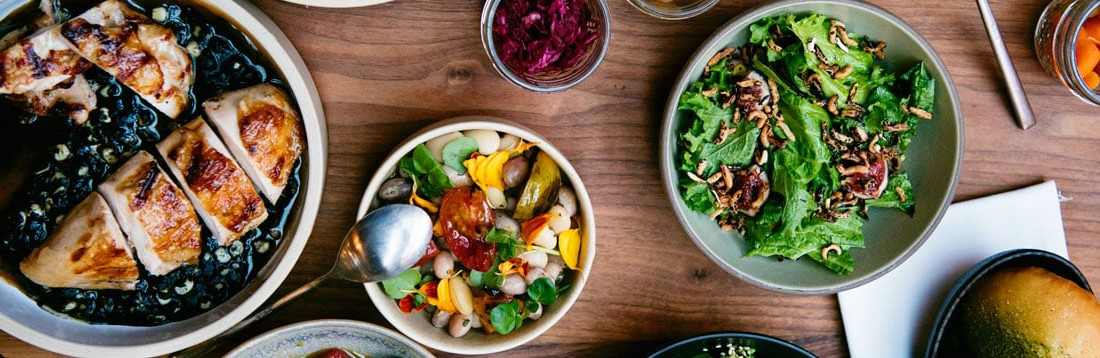

Dataset:  

    The dataset has details of various restaurants and the cost of the food served by them across different cities in India. 



Input variables:  

    TITLE: The feature of the restaurant which can help identify what and for whom it is suitable for.
    RESTAURANT_ID: A unique ID for each restaurant.
    CUISINES: The variety of cuisines that the restaurant offers.
    TIME: The open hours of the restaurant.
    CITY: The city in which the restaurant is located.
    LOCALITY: The locality of the restaurant.
    RATING: The average rating of the restaurant by customers.
    VOTES: The overall votes received by the restaurant.
 

Output variable:   

    COST: The average cost of a two-person meal.
 

Aim: 

    Analyse the dataset for insights.
    Develop a machine learning model to predict the cost of a two person meal. (Regression model)

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [191]:
food_train_df=pd.read_excel(r"C:\Users\gowri\Downloads\Data_Train.xlsx")
food_train_df.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


# Data pre-processing & EDA

In [192]:
# create copy of food_train_df before pre-processing

food_train_df1=food_train_df.copy()

In [193]:
food_train_df1.shape

(12690, 9)

In [194]:
food_train_df1.describe()

,RESTAURANT_ID,COST
count,12690.000000,12690.000000
mean,7759.134121,655.252246
std,4504.874150,627.003540
min,0.000000,20.000000
25%,3863.250000,300.000000
50%,7740.000000,500.000000
75%,11688.750000,800.000000
max,15573.000000,14000.000000


Observations:  

    The cost of two person meals ranged from ₹20 to ₹14,000 across various restaurants in India with ₹500 being the median cost.  


In [195]:
food_train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TITLE          11687 non-null  object
 1   RESTAURANT_ID  12690 non-null  int64 
 2   CUISINES       12690 non-null  object
 3   TIME           12690 non-null  object
 4   CITY           12578 non-null  object
 5   LOCALITY       12592 non-null  object
 6   RATING         12688 non-null  object
 7   VOTES          11486 non-null  object
 8   COST           12690 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 892.4+ KB


In [196]:
# define function for detecting and removing duplicates

def remove_duplicates (df):
    # checking for duplicates
    duplicates=df.duplicated()
    print(f'Number of duplicates in the dataset: {duplicates.sum()}')
    
    # remove duplicated record
    df.drop_duplicates(inplace=True)
    print('No. of duplicates after cleaning: ', df.duplicated().sum())
    print('No. of rows after cleaning: ', df.shape[0])

In [197]:
remove_duplicates(food_train_df1)

Number of duplicates in the dataset: 25
No. of duplicates after cleaning:  0
No. of rows after cleaning:  12665


In [198]:
# check number of unique values in each feature column
unique=food_train_df1.nunique()
pd.DataFrame(unique,columns=['No. of unique values'])

,No. of unique values
TITLE,112
RESTAURANT_ID,11892
CUISINES,4155
TIME,2689
CITY,359
LOCALITY,1416
RATING,32
VOTES,1847
COST,86


In [199]:
food_train_df1.isnull().sum()

TITLE            1000
RESTAURANT_ID       0
CUISINES            0
TIME                0
CITY              112
LOCALITY           98
RATING              2
VOTES            1200
COST                0
dtype: int64

Observations:  

There are nulls in the columns: title, city, locality, rating and votes

In [200]:
food_train_df1[food_train_df1['TITLE'].isna()]

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
22,NaN,12499,"North Indian, Fast Food, Mughlai, Rolls",11am – 3am (Mon-Sun),New Delhi,SDA,4.0,1191 votes,450
69,NaN,11096,"Pizza, Fast Food",11am – 11pm (Mon-Sun),New Delhi,Kalkaji,NEW,NaN,200
83,NaN,1100,"Chinese, Thai, Asian, Malaysian, Vietnamese, J...",12noon – 1am (Mon-Sun),New Delhi,East of Kailash,4.2,1120 votes,1500
93,NaN,7400,"Italian, Continental, Chinese, Thai, American,...",9pm – 7am (Mon-Sun),Bangalore,BTM,3.4,15 votes,300
102,NaN,14529,"Burger, Sandwich","11am – 10pm (Mon, Tue, Wed, Thu, Fri, Sun), 11...",Chennai,Purasaiwalkam,3.5,27 votes,200
...,...,...,...,...,...,...,...,...,...
12656,NaN,2249,"Burger, Fast Food",12noon – 4am (Mon-Sun),New Delhi,Rajouri Garden,4.2,647 votes,450
12658,NaN,9384,"Kerala, South Indian",11am – 5pm (Mon-Sun),Kochi,Chittoor Road,NEW,NaN,400
12665,NaN,5679,"Salad, Healthy Food, Beverages, Continental",11:30am – 10pm (Mon-Sun),Faridabad,NIT,3.9,38 votes,200
12673,NaN,12011,"Fast Food, Rolls",11:30am – 10:30pm (Mon-Sun),New Delhi,Karol Bagh,4.0,617 votes,250


In [201]:
# function to create new column SINGLE_TITLE from TITLE and to fill nulls in SINGLE_TITLE

def create_single_title(df):
    
    print('Number of nulls in title column is : ',df['TITLE'].isnull().sum())
    df['TITLE'].replace(np.nan,'',inplace=True)
    
    SINGLE_TITLE=[]
    for i in df['TITLE']:
        if i!= '':
            title=i.split(',')[0]
            SINGLE_TITLE.append(title)
        else:
            SINGLE_TITLE.append('')
            
    df.insert(2, 'SINGLE_TITLE',SINGLE_TITLE)
    df.drop('TITLE',axis=1,inplace=True)
    
    df['SINGLE_TITLE'].replace('','Unknown', inplace=True)
    print('Number of nulls in SINGLE_TITLE column after filling is : ',df['SINGLE_TITLE'].isnull().sum())
    
    return df.head()

In [202]:
create_single_title(food_train_df1)

Number of nulls in title column is :  1000
Number of nulls in SINGLE_TITLE column after filling is :  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,9438,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,13198,CASUAL DINING,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,10915,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,6346,QUICK BITES,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,15387,DESSERT PARLOR,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [203]:
food_train_df1[food_train_df1['CITY'].isna()]

,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
129,9101,Unknown,"North Indian, South Indian, Chinese, Continental","12noon – 3pm, 7pm – 2am (Mon-Sun)",NaN,NaN,3.6,728 votes,500
246,14502,QUICK BITES,Biryani,12noon – 11pm (Mon-Sun),NaN,Palarivattom Kochi,3.4,82 votes,300
411,6313,Unknown,"North Indian, Chinese, Pizza, Burger, Fast Food",7pm – 4am (Mon-Sun),NaN,NaN,4.0,29 votes,600
466,1133,Unknown,North Indian,4pm – 9pm (Mon-Sun),NaN,NaN,4.2,55 votes,200
481,4788,Unknown,Street Food,"11am – 11pm (Mon),9:30am – 12midnight (Tue-Sun)",NaN,NaN,3.7,616 votes,250
...,...,...,...,...,...,...,...,...,...
12280,3446,Unknown,"North Indian, Chinese",5pm – 5am (Mon-Sun),NaN,NaN,3.7,281 votes,500
12314,11724,CASUAL DINING,"North Indian, Bengali","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",NaN,Opposite to corporation bank and LIC office ba...,4.3,775 votes,650
12447,7314,QUICK BITES,"North Indian, Chinese, Mughlai, Seafood",12:30pm – 12midnight (Mon-Sun),NaN,Hyderabad,3.1,44 votes,350
12567,15532,Unknown,"Biryani, Chinese, Fast Food, North Indian","11am – 1am (Mon, Sun), 11am – 12:15AM (Tue-Sat)",NaN,NaN,3.7,656 votes,300


In [204]:
# function to create new column LOCATION from CITY and LOCALITY and to fill nulls in LOCATION column

def handle_location_nulls(df):
    print('Number of nulls in city : ', df['CITY'].isnull().sum())
    print('Number of nulls in locality: ', df['LOCALITY'].isnull().sum())
    df['CITY'].fillna('',inplace=True)
    df['LOCALITY'].fillna('',inplace=True)
    df['LOCATION']=df['CITY']+ ' '+ df['LOCALITY']
    print('Number of nulls after combining city and locality as LOCATION: ', df['LOCATION'].isnull().sum())
    
    df.drop(['CITY','LOCALITY'],axis=1,inplace=True)
    return df.head()

In [205]:
handle_location_nulls(food_train_df1)

Number of nulls in city :  112
Number of nulls in locality:  98
Number of nulls after combining city and locality as LOCATION:  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,RATING,VOTES,COST,LOCATION
0,9438,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",3.6,49 votes,1200,Thane Dombivali East
1,13198,CASUAL DINING,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),4.2,30 votes,1500,Chennai Ramapuram
2,10915,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",3.8,221 votes,800,Chennai Saligramam
3,6346,QUICK BITES,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),4.1,24 votes,800,Mumbai Bandra West
4,15387,DESSERT PARLOR,Desserts,11am – 1am (Mon-Sun),3.8,165 votes,300,Mumbai Lower Parel


In [206]:
# fill nulls in rating column

food_train_df1['RATING'].value_counts()

RATING
3.9    1233
3.8    1187
4.0    1094
3.7    1086
3.6     951
4.1     933
3.5     768
4.2     723
NEW     704
3.4     574
4.3     556
-       494
3.3     365
4.4     362
3.2     266
4.5     199
2.9     186
3.1     186
3.0     170
2.8     146
4.6     141
2.7      89
4.7      68
2.6      61
2.5      35
4.8      32
4.9      22
2.4      15
2.3      10
2.1       3
2.0       2
2.2       2
Name: count, dtype: int64

In [207]:
# function to fill nulls in RATING column

def handle_rating_nulls(df):
    print('Number of nulls initially in RATING column: ', df['RATING'].isnull().sum())
    df['RATING'].replace(['NEW','-'], np.nan, inplace=True)
    df['RATING']=df['RATING'].astype('float')
    df['RATING'].fillna(df['RATING'].median(),inplace=True)
    print('Number of nulls in RATING column after imputation: ', df['RATING'].isnull().sum())
    return df.head()

In [208]:
handle_rating_nulls(food_train_df1)

Number of nulls initially in RATING column:  2
Number of nulls in RATING column after imputation:  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,RATING,VOTES,COST,LOCATION
0,9438,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",3.6,49 votes,1200,Thane Dombivali East
1,13198,CASUAL DINING,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),4.2,30 votes,1500,Chennai Ramapuram
2,10915,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",3.8,221 votes,800,Chennai Saligramam
3,6346,QUICK BITES,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),4.1,24 votes,800,Mumbai Bandra West
4,15387,DESSERT PARLOR,Desserts,11am – 1am (Mon-Sun),3.8,165 votes,300,Mumbai Lower Parel


In [209]:
# fill nulls in VOTES column

food_train_df1['VOTES'].value_counts()

VOTES
44 votes      71
29 votes      66
38 votes      65
28 votes      65
35 votes      64
              ..
2500 votes     1
3052 votes     1
1020 votes     1
4634 votes     1
1214 votes     1
Name: count, Length: 1847, dtype: int64

In [210]:
# function to fill nulls in VOTES column and add a derived VOTES_NUM column

def handle_vote_nulls(df):
    
    print('Number of nulls initially in VOTES column: ', df['VOTES'].isnull().sum())
    mode_votes=df['VOTES'].mode().iloc[0]
    df['VOTES'].fillna(mode_votes,inplace=True)
    print('Number of nulls in VOTES column after imputation: ', df['VOTES'].isnull().sum())
    VOTES_NUM=[]

    for i in df['VOTES']:   
        num=re.findall(r'\d+', i)
        VOTES_NUM.append(num[0])
        
    df['VOTES_NUM']=VOTES_NUM
    df.drop('VOTES',axis=1, inplace=True)
    
    return df.head()

In [211]:
handle_vote_nulls(food_train_df1)

Number of nulls initially in VOTES column:  1200
Number of nulls in VOTES column after imputation:  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,RATING,COST,LOCATION,VOTES_NUM
0,9438,CASUAL DINING,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",3.6,1200,Thane Dombivali East,49
1,13198,CASUAL DINING,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),4.2,1500,Chennai Ramapuram,30
2,10915,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",3.8,800,Chennai Saligramam,221
3,6346,QUICK BITES,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),4.1,800,Mumbai Bandra West,24
4,15387,DESSERT PARLOR,Desserts,11am – 1am (Mon-Sun),3.8,300,Mumbai Lower Parel,165


In [212]:
# confirm that all nulls are filled

food_train_df1.isnull().sum()

RESTAURANT_ID    0
SINGLE_TITLE     0
CUISINES         0
TIME             0
RATING           0
COST             0
LOCATION         0
VOTES_NUM        0
dtype: int64

In [213]:
# drop RESTAURANT_ID column
food_train_df1.drop('RESTAURANT_ID',axis=1,inplace=True)

In [214]:
# counting unique values in each column

for i in food_train_df1.columns:
    print(food_train_df1[i].value_counts())

SINGLE_TITLE
QUICK BITES       4330
CASUAL DINING     4114
Unknown           1000
CAFÉ               748
DESSERT PARLOR     477
BAKERY             462
FINE DINING        350
BAR                254
BEVERAGE SHOP      213
LOUNGE             153
PUB                103
SWEET SHOP         102
FOOD COURT          93
KIOSK               56
MESS                53
DHABA               45
MICROBREWERY        43
FOOD TRUCK          30
CLUB                23
COCKTAIL BAR         6
PAAN SHOP            4
MEAT SHOP            3
CONFECTIONERY        3
Name: count, dtype: int64
CUISINES
South Indian                                532
North Indian                                524
North Indian, Chinese                       500
Fast Food                                   286
Chinese                                     167
                                           ... 
BBQ, Rolls                                    1
Italian, North Indian, Chinese, Salad         1
Andhra, Seafood, Biryani               

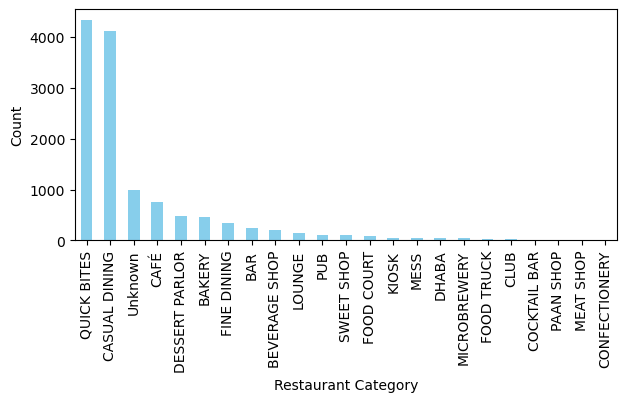

In [215]:
# plot count of Restaurant Categories

plt.figure(figsize=(7,3))
food_train_df1['SINGLE_TITLE'].value_counts().plot(kind='bar',color='skyblue')
plt.xlabel('Restaurant Category')
plt.ylabel('Count')

plt.show()

Observation:  

    QUICK BITES restaurant category has appeared the most in the dataset while CONFECTIONARY is the least appeared.
    

In [216]:
# select top 10 cities for better visualization

city=food_train_df['CITY'].value_counts()
city_count=city.head(10)
city_count

CITY
Chennai         2174
Bangalore       2149
Hyderabad       1819
Mumbai          1722
New Delhi       1321
Kochi           1279
Gurgaon          379
Secunderabad     310
Noida            211
Navi Mumbai      165
Name: count, dtype: int64

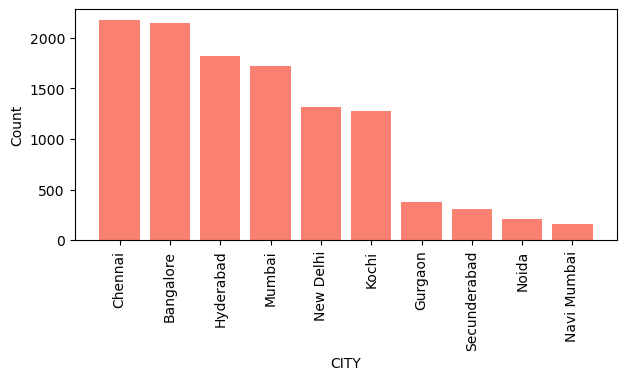

In [217]:
# plot count of Restaurant Categories

plt.figure(figsize=(7,3))
plt.bar(city_count.index, city_count.values,color='salmon')

plt.xlabel('CITY')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Observation:  

    The graph shows the top 10 cities featured in the dataset  
    Chennai is represented more in the dataset immediately followed by Bangalore

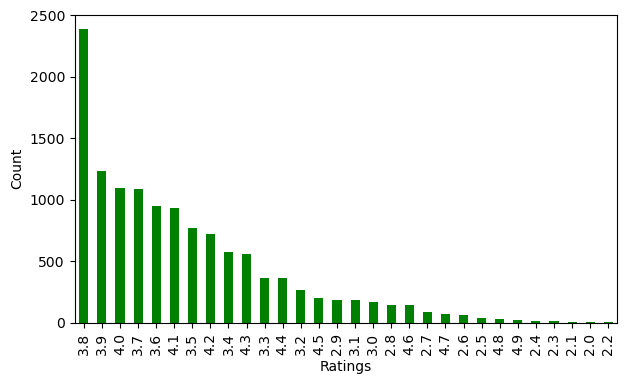

In [218]:
# plot count of Restaurant Ratings

plt.figure(figsize=(7,4))
food_train_df1['RATING'].value_counts().plot(kind='bar', color='green')

plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Observation:  

    Most frequently observed restaurant rating is 3.8  
    Majority restaurants are rated as average and occurence of very good and very bad ratings are less frequent 
    

In [219]:
# select top 10 cuisines for better visualization

cuisines=food_train_df['CUISINES'].value_counts()
cuisines_count=cuisines.head(10)
cuisines_count

CUISINES
South Indian                           532
North Indian                           526
North Indian, Chinese                  501
Fast Food                              286
Chinese                                167
Bakery                                 148
Bakery, Desserts                       148
South Indian, North Indian, Chinese    139
Cafe                                   134
Kerala                                 131
Name: count, dtype: int64

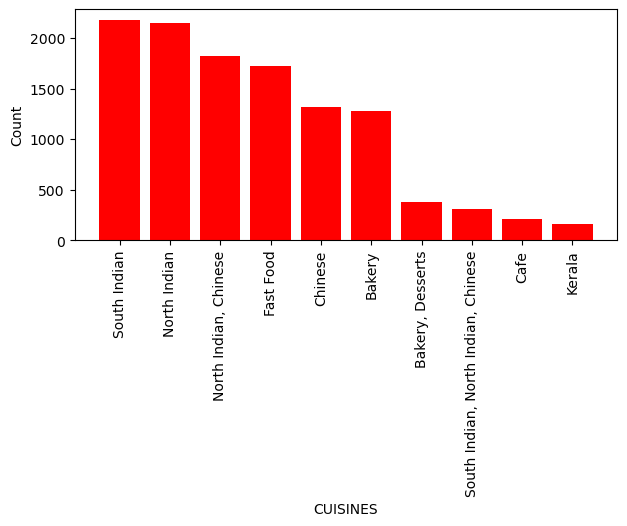

In [220]:
# plot top 10 cuisines

plt.figure(figsize=(7,3))
plt.bar(cuisines_count.index, city_count.values,color='red')

plt.xlabel('CUISINES')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Observation:  

    South Indian cuisines are more represented in the dataset immediately followed by North Indian cuisine.

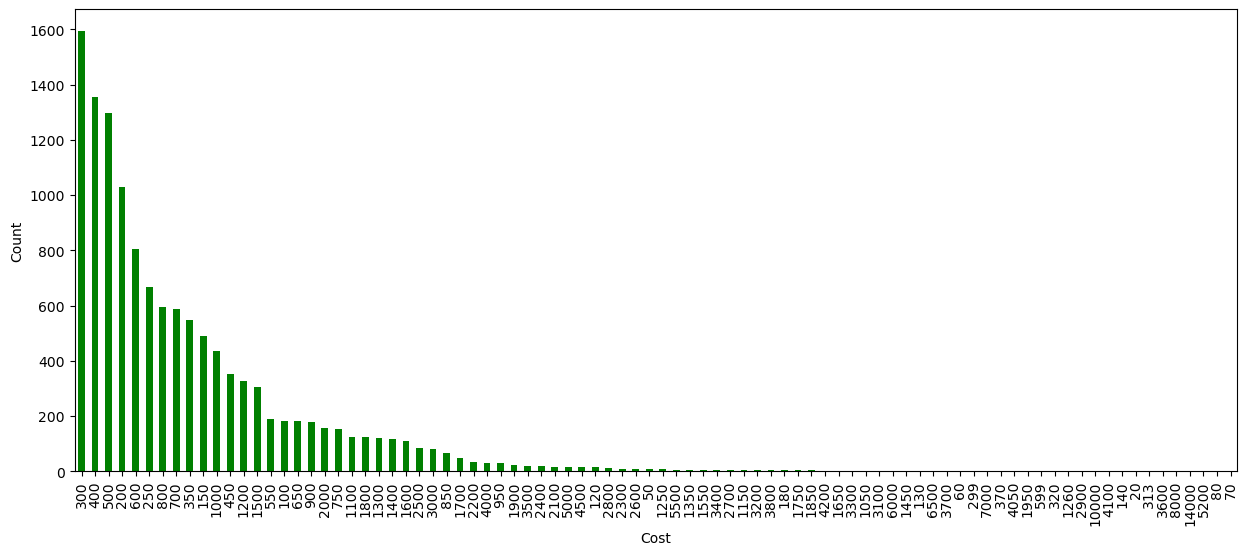

In [221]:
# plot cost count

plt.figure(figsize=(15,6))
food_train_df1['COST'].value_counts().plot(kind='bar', color='green')

plt.xlabel('Cost')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Observation:  

    Around 1600 restaurants have been charging Rs.300 for two people meals (most frequently charged amount is Rs. 300)  

In [391]:
# define function to encode categorical_features for checking correlation

def encode_categorical_features(df):
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()
    
    categorical=df.select_dtypes(include='object')
    for i in categorical.columns:
        df[i]=le.fit_transform(df[i])
    return df    

In [392]:
encode_categorical_features(food_train_df1)

,SINGLE_TITLE,CUISINES,TIME,RATING,COST,LOCATION,VOTES_NUM
0,4,2627,739,3.6,1200,1600,1278
1,4,289,1885,4.2,1500,409,950
2,4,2976,661,3.8,800,414,712
3,20,4130,275,4.1,800,1047,787
4,8,1766,615,3.8,300,1105,470
...,...,...,...,...,...,...,...
12685,20,2934,1144,3.8,500,707,1349
12686,4,2143,1177,4.3,1800,1046,191
12687,14,2088,1137,4.0,1300,1205,1428
12688,4,3506,1837,3.5,400,348,996


Observations:  

    Data is normally distributed in all feature columns  
    Label column (cost) is left skewed as the restaurant data has outliers. The outliers are not removed as it contains valuable information.

# Feature Selection

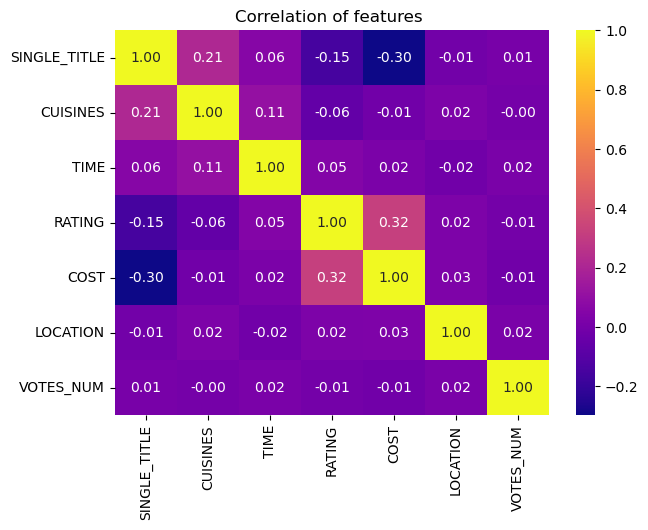

In [393]:
# correlation matrix

cm= food_train_df1.corr()
plt.figure(figsize=(7,5))

sns.heatmap(cm, annot=True,cmap='plasma',fmt='.2f')
plt.title('Correlation of features ')
plt.show()

Observations:  

    Cost shows moderate positive correlation with rating and moreate negative correlation with restaurant category (SINGLE_TITLE)  
    Highly rated meals tend to be expensive  
    Restaurant categories can be further classified based on costs as they have correlation and can be used for further analysis.
    Other features show weak/less significant correlations with each other (chance for multicollinearity is less)

In [394]:
# confirm multicollinearity by vif

x=food_train_df1.drop('COST',axis=1)
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

vif=pd.DataFrame()
vif['Features']=x.columns
vif['VIF']=[variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif.sort_values(by='VIF',ascending=False)

,Features,VIF
0,SINGLE_TITLE,1.071966
1,CUISINES,1.059865
3,RATING,1.029275
2,TIME,1.016897
4,LOCATION,1.002048
5,VOTES_NUM,1.000679


Observation:  

    There is no evidence of multicollinearity and all the features could be selected for model training.

In [395]:
# splitting dataset into x and y sets

x= food_train_df1.drop(['COST'],axis=1) 

y = food_train_df1['COST']


In [396]:
# transforming and splitting training and testing sets

scaler = StandardScaler()
x_scaled =scaler.fit_transform(x)

x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,random_state=67)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(9498, 6) (3167, 6) (9498,) (3167,)


# MODEL BUILDING & VALIDATION

In [397]:
# define functions for training and preliminary evaluation of models

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def score(model,x_train,y_train,x_test,y_test,train=True):
    model_metrics=[]
    if train:
        y_pred1= model.predict(x_train)
    else:
        y_pred2= model.predict(x_test)
        r2=r2_score(y_test,y_pred2)
        cv=cross_val_score(model,x_scaled,y,cv=5).mean()
        print('R2 score: ',r2_score(y_test,y_pred2))


In [398]:
# linear Regression

from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train,y_train)
score(lr,x_train,y_train,x_test,y_test,train=True)
score(lr,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.17216988494649887


In [399]:
# Ridge

from sklearn.linear_model import Ridge
ridge=Ridge()
ridge.fit(x_train,y_train)
score(ridge,x_train,y_train,x_test,y_test,train=True)
score(ridge,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.1721678775843999


In [400]:
# Lasso

from sklearn.linear_model import Lasso
lasso=Lasso()
lasso.fit(x_train,y_train)
score(lasso,x_train,y_train,x_test,y_test,train=True)
score(lasso,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.17194206503810383


In [401]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor()
rfr.fit(x_train,y_train)
score(rfr,x_train,y_train,x_test,y_test,train=True)
score(rfr,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.6938497208693905


In [402]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor
gbdt=GradientBoostingRegressor()
gbdt.fit(x_train,y_train)
score(gbdt,x_train,y_train,x_test,y_test,train=True)
score(gbdt,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.6676383871805384


In [403]:
# XGBoost

import xgboost as xgb
xgbr=xgb.XGBRegressor()
xgbr.fit(x_train,y_train)

score(xgbr,x_train,y_train,x_test,y_test,train=True)
score(xgbr,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.7171160958278117


In [404]:
# Evaluate the models based on metrics

def evaluation(model):
    
    model_metrics=[]
    
    for name, model in models.items():
        model.fit(x_train,y_train)
        y_pred2= model.predict(x_test)
        r2=r2_score(y_test,y_pred2)
        mse=mean_squared_error(y_test,y_pred2)
        mae=mean_absolute_error(y_test,y_pred2)
        cv=cross_val_score(model,x,y,cv=5).mean()
        diff = abs(r2-cv)
        
        model_metrics.append({'Model':name, 'R2 score':r2, 'Mean Squared Error':mse,
                              'Mean Absolute Error':mae, 'Cross Validation':cv,'Diff btw R2 and CV': diff})
        models_table=pd.DataFrame(model_metrics)
        
    return models_table.sort_values(by='R2 score' ,ascending=False)

In [405]:
models={'Linear Regression':lr, 'Lasso':lasso,'Ridge':ridge, 'Random Forest':rfr,
        'Gradient Boosting':gbdt,'XGBoost':xgbr }

evaluation(models)

,Model,R2 score,Mean Squared Error,Mean Absolute Error,Cross Validation,Diff btw R2 and CV
5,XGBoost,0.717116,118886.996933,203.797532,0.717087,0.000029
3,Random Forest,0.694673,128319.294749,203.612933,0.700920,0.006247
4,Gradient Boosting,0.667638,139680.884848,216.328259,0.685961,0.018322
0,Linear Regression,0.172170,347910.343777,348.633176,0.168668,0.003502
2,Ridge,0.172168,347911.187407,348.630972,0.168669,0.003499
1,Lasso,0.171942,348006.089149,348.466827,0.168678,0.003264


Observation:
    XGBoost Regressor is seen as the best model among the 8 models for this regression task with:
    
       * R2 score: 0.71
       * Cross Validation: 0.71

In [406]:
# Hyperparameter tuning of XGBoost Regressor model

from sklearn.model_selection import RandomizedSearchCV

params={'max_depth':range(2,8), 'min_samples_split': range(2,10), 'n_estimators': range(50,300,50),
        'learning_rate': [0.01,0.05,0.08,0.1,0.2,0.5]}

rs= RandomizedSearchCV(xgb.XGBRegressor(),param_distributions=params,cv=5,scoring='r2')
rs.fit(x_train,y_train)
print(f'Best parameters for Gradient Boosting Regressor model: {rs.best_params_} \n Best score: {rs.best_score_}')

Best parameters for Gradient Boosting Regressor model: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 6, 'learning_rate': 0.2} 
 Best score: 0.7200323091736356


In [420]:
# Tuned XGBoost (manual tuning also done)

xgbr1=xgb.XGBRegressor(n_estimators= 195, min_samples_split= 3, max_depth= 7, learning_rate= 0.079)
xgbr1.fit(x_train,y_train)

score(xgbr1,x_train,y_train,x_test,y_test,train=True)
score(xgbr1,x_train,y_train,x_test,y_test,train=False)

R2 score:  0.7234018650993994


In [421]:
models={'XGBoost':xgbr,'Tuned XGBoost':xgbr1 }

evaluation(models)

,Model,R2 score,Mean Squared Error,Mean Absolute Error,Cross Validation,Diff btw R2 and CV
1,Tuned XGBoost,0.723402,116245.290491,195.090214,0.716235,0.007167
0,XGBoost,0.717116,118886.996933,203.797532,0.717087,0.000029


Observation:  

    Hyperparameter tuning has improved the R2 score and cross validation score while decreased the MSE and MAE.
    So we could save this tuned model.


In [422]:
# save the model
pickle.dump(xgbr1, open('Restaurant_Cost_Prediction_xgbr1.pkl','wb'))

# Testing the selected model with test data

In [448]:
# load test data

food_test_df=pd.read_excel(r"C:\Users\gowri\Downloads\Data_Test.xlsx")
food_test_df.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,NaN,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


In [449]:
food_test_df.shape

(4231, 8)

In [450]:
# handle nulls in the test data

remove_duplicates(food_test_df)

Number of duplicates in the dataset: 1
No. of duplicates after cleaning:  0
No. of rows after cleaning:  4230


In [451]:
create_single_title(food_test_df)

Number of nulls in title column is :  284
Number of nulls in SINGLE_TITLE column after filling is :  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,4085,CASUAL DINING,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,12680,QUICK BITES,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,1411,CASUAL DINING,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,204,Unknown,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,13453,QUICK BITES,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


In [452]:
handle_location_nulls(food_test_df)

Number of nulls in city :  35
Number of nulls in locality:  30
Number of nulls after combining city and locality as LOCATION:  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,RATING,VOTES,LOCATION
0,4085,CASUAL DINING,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),4.3,564 votes,Noida Sector 18
1,12680,QUICK BITES,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),4.2,61 votes,Mumbai Grant Road
2,1411,CASUAL DINING,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),3.8,350 votes,Mumbai Marine Lines
3,204,Unknown,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",3.8,1445 votes,Faridabad NIT
4,13453,QUICK BITES,"South Indian, Kerala",11am – 10pm (Mon-Sun),3.6,23 votes,Kochi Kaloor


In [453]:
handle_rating_nulls(food_test_df)

Number of nulls initially in RATING column:  2
Number of nulls in RATING column after imputation:  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,RATING,VOTES,LOCATION
0,4085,CASUAL DINING,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),4.3,564 votes,Noida Sector 18
1,12680,QUICK BITES,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),4.2,61 votes,Mumbai Grant Road
2,1411,CASUAL DINING,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),3.8,350 votes,Mumbai Marine Lines
3,204,Unknown,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",3.8,1445 votes,Faridabad NIT
4,13453,QUICK BITES,"South Indian, Kerala",11am – 10pm (Mon-Sun),3.6,23 votes,Kochi Kaloor


In [454]:
handle_vote_nulls(food_test_df)

Number of nulls initially in VOTES column:  402
Number of nulls in VOTES column after imputation:  0


,RESTAURANT_ID,SINGLE_TITLE,CUISINES,TIME,RATING,LOCATION,VOTES_NUM
0,4085,CASUAL DINING,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),4.3,Noida Sector 18,564
1,12680,QUICK BITES,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),4.2,Mumbai Grant Road,61
2,1411,CASUAL DINING,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),3.8,Mumbai Marine Lines,350
3,204,Unknown,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",3.8,Faridabad NIT,1445
4,13453,QUICK BITES,"South Indian, Kerala",11am – 10pm (Mon-Sun),3.6,Kochi Kaloor,23


In [455]:
# create a copy of the cleaned dataset

food_test_df1=food_test_df.copy()

In [456]:
# drop RESTAURANT_ID column

food_test_df1.drop('RESTAURANT_ID',axis=1,inplace=True)

In [457]:
print(f'Shape of test data after handling nulls: {food_test_df1.shape}')

Shape of test data after handling nulls: (4230, 6)


In [460]:
# encode the test features

encoded_test=encode_categorical_features(food_test_df1)
encoded_test

,SINGLE_TITLE,CUISINES,TIME,RATING,LOCATION,VOTES_NUM
0,5,1293,503,4.3,837,823
1,21,1632,933,4.2,602,871
2,5,1455,219,3.8,621,575
3,23,208,1071,3.8,283,179
4,21,1637,208,3.6,510,394
...,...,...,...,...,...,...
4226,5,1425,103,3.9,791,487
4227,23,267,262,4.3,47,722
4228,21,679,1052,3.7,293,789
4229,21,1541,215,3.8,511,861


In [461]:
# scale the encoded features before prediction

x_test_scaled =scaler.fit_transform(encoded_test)

In [462]:
# predict subscription with x_test_scaled using tuned XGBoost model

Food_cost_prediction_model=pickle.load(open('Restaurant_Cost_Prediction_xgbr1.pkl','rb'))
y_pred=Food_cost_prediction_model.predict(x_test_scaled)

In [463]:
# make a dataframe with client id and predictions of whether the client will subscribe for term deposit or not?

y_pred_df=pd.DataFrame()
y_pred_df['Restaurant ID']=food_test_df['RESTAURANT_ID'].values
y_pred_df['Cost of two person meal']=y_pred
y_pred_df

,Restaurant ID,Cost of two person meal
0,4085,1022.484253
1,12680,291.714233
2,1411,699.048096
3,204,302.261017
4,13453,376.777161
...,...,...
4225,9057,867.643677
4226,1247,688.460632
4227,8617,416.596985
4228,6485,459.326141


# Overall Summary

The dataset on "Restaurant Food Cost" was used to analyse and build machine learning models (binary classification) to predict the cost of a two person meal (Regression model).

# Data Insights

     The cost of two person meals ranged from ₹20 to ₹14,000 across various restaurants in India with ₹500 being the median cost  
     QUICK BITES restaurant category has appeared the most in the dataset while CONFECTIONARY is the least appeared
     Chennai is represented more in the dataset immediately followed by Bangalore
     Most frequently observed restaurant rating is 3.8. Majority restaurants are rated as average and occurence of very good and very bad ratings are less frequent
     South Indian cuisines are more represented in the dataset immediately followed by North Indian cuisine
     Around 1600 restaurants have been charging Rs.300 for two people meals (most frequently charged amount is Rs. 300) 
     Cost shows moderate positive correlation with rating and moreate negative correlation with restaurant category (SINGLE_TITLE)  
     Highly rated meals tend to be expensive  
     Restaurant categories can be further classified based on costs as they have correlation and can be used for further analysis.


# Selected model


XGBoost Regressor (xgbr1) is found to be the best model among the 6 models for this regression task with:

   * R2 score: 0.72
   * Cross Validation: 0.71
   * MSE: 116245.29
   * MAE: 195.09
   * Diff btw R2 and CV scores: 0.007
   
